In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

Download datasets

In [2]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_100y = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_100y.scv = dataset_100y.scv.groupby('dataset').get_group('100y')
dataset_100y.scv_imputed = dataset_100y.scv_imputed.groupby('dataset').get_group('100y')

Dataset loaded from ../datasets/power_transitions.xlsx
Dataset loaded from ../datasets/power_transitions.xlsx
Dataset loaded from ../datasets/power_transitions.xlsx


# Calculate MSP

impute MSP

In [3]:
religion_df = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='Religion')
dataset_PT.scv.MSP = dataset_PT.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP.values[0] if x in religion_df.PolID.values else np.nan)
dataset_PT.scv_imputed['MSP'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

dataset_PT.scv_imputed['religion'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
dataset_PT.scv_imputed['religion_family'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
dataset_FULL.scv_imputed['MSP'] = dataset_FULL.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_81395/2006270674.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset_PT.scv.MSP = dataset_PT.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP.values[0] if x in religion_df.PolID.values else np.nan)


Add crisis variables

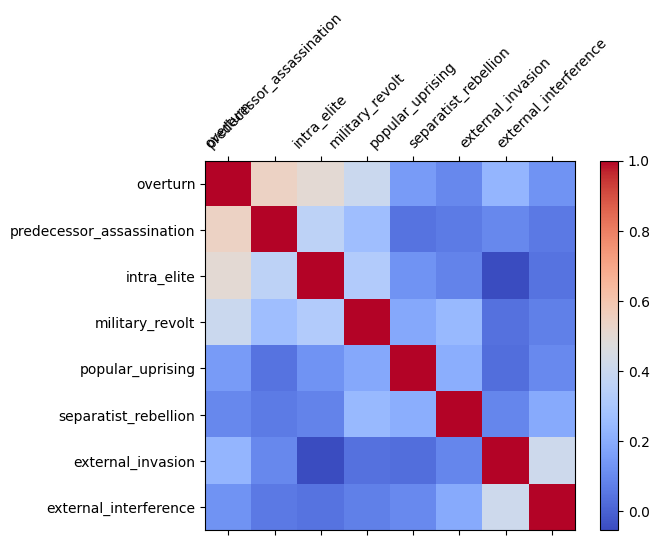

In [4]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
PT_mapping = {'PT_types':{}}
for c,col in enumerate(crisis_vars):
    if c < 5:
        PT_mapping['PT_types'][col] = 1
    dataset_PT.scv[col] = dataset_PT.raw[col]
    dataset_PT.scv_imputed[col] = dataset_PT.scv[col]

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']
dataset_PT.scv['duration'] = dataset_PT.raw['duration']
dataset_PT.scv_imputed['duration'] = dataset_PT.scv['duration']

# plot correlation matrix between crisis variables
corr = dataset_PT.scv[crisis_vars].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(cax)
plt.show()

Check for missing data

In [5]:
dataset_PT.scv

,NGA,PolityID,PolityName,Year,Pop,Terr,Cap,Hierarchy,Government,Infrastructure,...,overturn,predecessor_assassination,intra_elite,military_revolt,popular_uprising,separatist_rebellion,external_invasion,external_interference,Crisis,duration
0,Middle Yellow River Valley,1,cn_qing_dyn_1,1661.0,8.084590,7.117271,5.887266,6.750000,0.888889,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Middle Yellow River Valley,1,cn_qing_dyn_1,1722.0,8.084590,7.117271,5.887266,6.750000,0.888889,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Middle Yellow River Valley,1,cn_qing_dyn_1,1735.0,8.084590,7.117271,5.887266,6.750000,0.888889,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Middle Yellow River Valley,1,cn_qing_dyn_1,1796.0,8.084590,7.117271,5.887266,6.750000,0.888889,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.2,0.0
4,Middle Yellow River Valley,2,cn_qing_dyn_2,1820.0,8.469822,7.053078,5.949825,6.729288,0.909091,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3164,NaN,811,hu_later_dyn,1458.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
3165,NaN,811,hu_later_dyn,1490.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.9,0.2,0.0
3166,NaN,811,hu_later_dyn,1516.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3167,NaN,811,hu_later_dyn,1526.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4,0.0


In [6]:
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
print(f"Missing rows in PT, total number of rows {len(dataset_PT.scv)}")
print('Missing rows in scale columns')
print(dataset_PT.scv_imputed[scale_cols].isna().any(axis=1).sum())
print("Missing rows in non-scale columns")
print(dataset_PT.scv_imputed[non_scale_cols].isna().any(axis=1).sum())
print("Missing rows in MSP")
print(dataset_PT.scv_imputed[['MSP']].isna().any(axis=1).sum())
print("Total not complete rows")
print(dataset_PT.scv_imputed[scale_cols+non_scale_cols+['MSP']].isna().any(axis=1).sum())

Missing rows in PT, total number of rows 3169
Missing rows in scale columns
414
Missing rows in non-scale columns
329
Missing rows in MSP
36
Total not complete rows
463


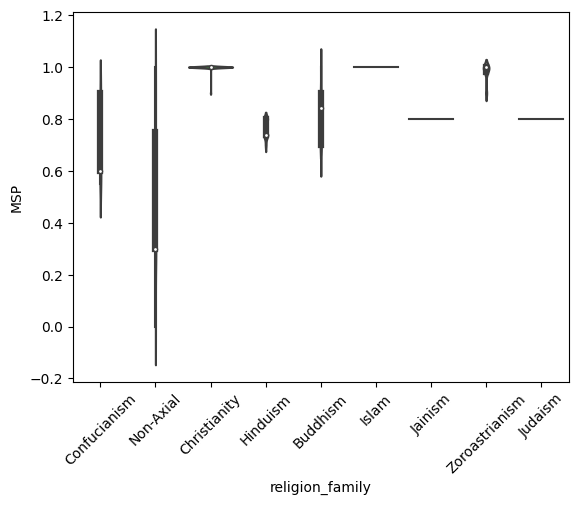

In [7]:
import seaborn as sns
sns.violinplot( data = dataset_PT.scv_imputed[['MSP', 'religion_family', 'Year']], x = 'religion_family', y = 'MSP')
# rotate x labels
plt.xticks(rotation=45)
plt.show()

# Calculate Scale, Comp and Miltech

In [8]:
comp_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset_PT.scv_imputed['nScale'] = dataset_PT.scv_imputed[scale_cols].notna().sum(axis=1)
dataset_PT.scv_imputed['nComp'] = dataset_PT.scv_imputed[comp_cols].notna().sum(axis=1)

Compute scale and non-scale PCA

In [9]:
scale_cols = ['Pop','Terr','Cap']
scale_pca = dataset_FULL.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
dataset_PT.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols), pca_func = scale_pca, contributions=True, rescale=True)
# rescale the PCA according to variable Pop
# lm = sm.OLS(dataset_PT.scv_imputed['Scale_1'], dataset_PT.scv_imputed['Pop']).fit()


# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset_PT.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset_PT.scv_imputed['Scale_1'] = (dataset_PT.scv_imputed['Scale_1'] - intercept) / slope

lm_df = dataset_FULL.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset_FULL.scv_imputed['Scale_1'] = (dataset_FULL.scv_imputed['Scale_1'] - intercept) / slope


there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.51%
PC2: 7.40%
PC3: 3.09%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 89.51%
PC2: 7.40%
PC3: 3.09%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57


In [10]:
inst_cols = ['Government', 'Infrastructure', 'Information', 'Money']
inst_pca = dataset_FULL.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols))
dataset_PT.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols), pca_func = inst_pca, contributions=True, rescale=True)
dataset_PT.scv_imputed['Inst_1'] = -dataset_PT.scv_imputed['Inst_1']

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 70.24%
PC2: 15.08%
PC3: 9.73%
PC4: 4.95%
there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 70.24%
PC2: 15.08%
PC3: 9.73%
PC4: 4.95%
PC1 contributions:
Government: -0.53
Infrastructure: -0.45
Information: -0.52
Money: -0.49


Compute COMP and MILTECH

In [11]:
dataset_PT.scv_imputed['Comp'] = (dataset_PT.scv_imputed['Government']*11 + dataset_PT.scv_imputed['Infrastructure']*12 + dataset_PT.scv_imputed['Information']*13 + dataset_PT.scv_imputed['Money']*6)/(11+13+12+6)
dataset_FULL.scv_imputed['Comp'] = (dataset_FULL.scv_imputed['Government']*11 + dataset_FULL.scv_imputed['Infrastructure']*12 + dataset_FULL.scv_imputed['Information']*13 + dataset_FULL.scv_imputed['Money']*6)/(11+13+12+6)
miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}

dataset_PT.scv['Miltech'] = dataset_PT.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Miltech'] = dataset_PT.scv['Miltech']
dataset_FULL.scv['Miltech'] = dataset_FULL.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)
dataset_FULL.scv_imputed['Miltech'] = dataset_FULL.scv['Miltech']

save new dataset

In [12]:
dataset_PT.save_dataset('../datasets', 'PT_dataset_imputed')

Dataset saved to ../datasets/PT_dataset_imputed.xlsx


# Plot scale and comp

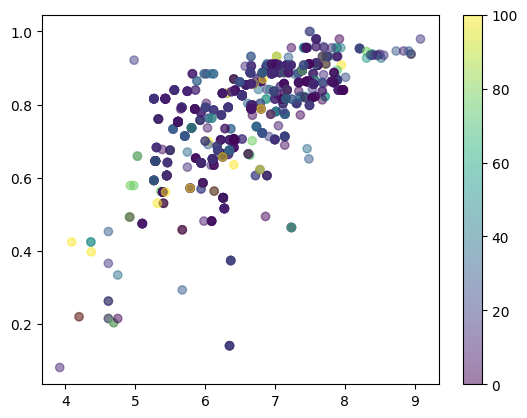

In [13]:

polity_group = dataset_PT.scv_imputed.groupby('PolityName')

plot_df = pd.DataFrame(columns=['PolityName', 'Comp', 'Scale_1', 'Peaceful_Period', 'Crisis'])
for name, group in polity_group:
    group = group.sort_values('Year')
    group['Crisis'] = group['Crisis'].mean()
    # remove rows with all crisis var equal to 0
    conflict_years = group[(group[crisis_vars] == 1).any(axis = 1)][['Year','Scale_1','Comp','Crisis']]
    if len(conflict_years) > 0:
        conflict_years['Duration'] = conflict_years.Year.diff()
        conflict_years = conflict_years.dropna(subset='Duration')
        new_row = pd.DataFrame({'PolityName': name, 'Comp': conflict_years['Comp'], 'Scale_1': conflict_years['Scale_1'], 'Peaceful_Period': conflict_years['Duration'], 'Crisis': conflict_years['Crisis']})
        plot_df = pd.concat([plot_df, new_row], ignore_index=True)
        plot_df.reset_index(drop=True, inplace=True)

plt.scatter(plot_df['Scale_1'], plot_df['Comp'], c=plot_df['Peaceful_Period'], cmap='viridis',alpha=0.5)
plt.clim(0, 100)
plt.colorbar()

1.0


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_81395/4043773969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_plot.sort_values('Crisis', inplace=True,ascending=True)


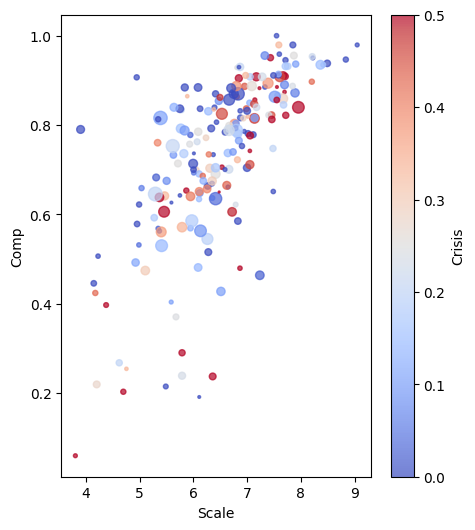

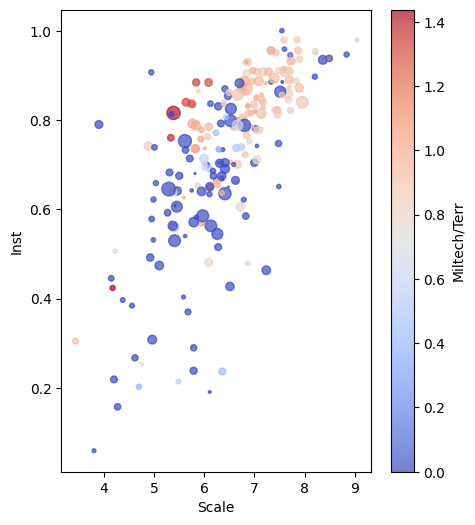

In [14]:
import matplotlib.pyplot as plt

dataset_plot = dataset_PT.scv_imputed.dropna(subset = ['Comp', 'Scale_1', 'predecessor_assassination'])
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')

fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]

print(mean_crisis.max())
v_max = mean_crisis.max()*0.5
v_min = mean_crisis.min()
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = v_min,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                    #   edgecolors=plt.cm.coolwarm((mean_crisis-v_min) / (v_max-v_min))
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

dataset_plot = dataset_PT.scv_imputed
dataset_plot['Miltech/Terr'] = dataset_plot['Miltech']/dataset_plot['Terr']
dataset_plot = dataset_plot.dropna(subset = ['Comp', 'Scale_1', 'Miltech/Terr'])
# dataset_plot = dataset_plot.loc[(dataset_plot.predecessor_assassination > 0) | (dataset_plot.Crisis == 0)]

polity_group = dataset_PT.scv_imputed.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Miltech/Terr'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()
v_min = 0
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = v_min,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                    #   edgecolors=plt.cm.coolwarm((mean_crisis-v_min) / (v_max-v_min))
                      )

# Add a color bar
plt.colorbar(scatter, label='Miltech/Terr')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()



# Run linear regression

Testing Scale and Comp only

In [15]:
import statsmodels.api as sm
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]


logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)
# Compute residuals
fitted_values = result.predict(X)  # Predicted probabilities
# deviance_residuals = result.resid_deviance  # Deviance residuals
pearson_residuals = result.resid_pearson    # Pearson residuals


Optimization terminated successfully.
         Current function value: 0.498943
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                 2169
Model:                                 Logit   Df Residuals:                     2166
Method:                                  MLE   Df Model:                            2
Date:                       Wed, 12 Mar 2025   Pseudo R-squ.:                0.009221
Time:                               09:20:43   Log-Likelihood:                -1082.2
converged:                              True   LL-Null:                       -1092.3
Covariance Type:                   nonrobust   LLR p-value:                 4.227e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        0.3819      0.080      4.782      0.0

Testing Miltech

In [16]:
regression_results = pd.DataFrame(columns = ['Crisis_type', 'Pop','Terr','Cap', 'Infrastructure', 'Information', 'Money', 'MSP','Miltech', 'Scale', 'Comp'])
for crisis in crisis_vars+['Crisis']:
    x_cols = ['Pop','Terr','Cap', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row = pd.DataFrame({'Crisis_type': crisis, 'Pop': p_vals['Pop'], 'Terr': p_vals['Terr'], 'Cap': p_vals['Cap'], 'Infrastructure': p_vals['Infrastructure'], 'Information': p_vals['Information'], 'Money': p_vals['Money'], 'MSP': p_vals['MSP'], 'Miltech': p_vals['Miltech'], 'Comp' : np.nan, 'Scale': np.nan}, index=[0])

    x_cols = ['Scale_1', 'Comp']
    y_col = crisis
    Xy = dataset_PT.scv_imputed
    Xy = Xy[[y_col]+x_cols].dropna()

    Xy['intercept'] = 1
    X = Xy[x_cols+ ['intercept']]
    y = Xy[y_col]

    if crisis == 'Crisis':
        model = sm.OLS(y, X)
        result = model.fit()
    else:
        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

    p_vals = result.pvalues
    row['Scale'] = p_vals['Scale_1']
    row['Comp'] = p_vals['Comp']
    regression_results = pd.concat([regression_results, row], ignore_index=True)

Optimization terminated successfully.
         Current function value: 0.626761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.631235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.654010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665217
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.413774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.268874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280465
  

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_81395/891266817.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 0.98, 'p-values for different crisis types and variables')

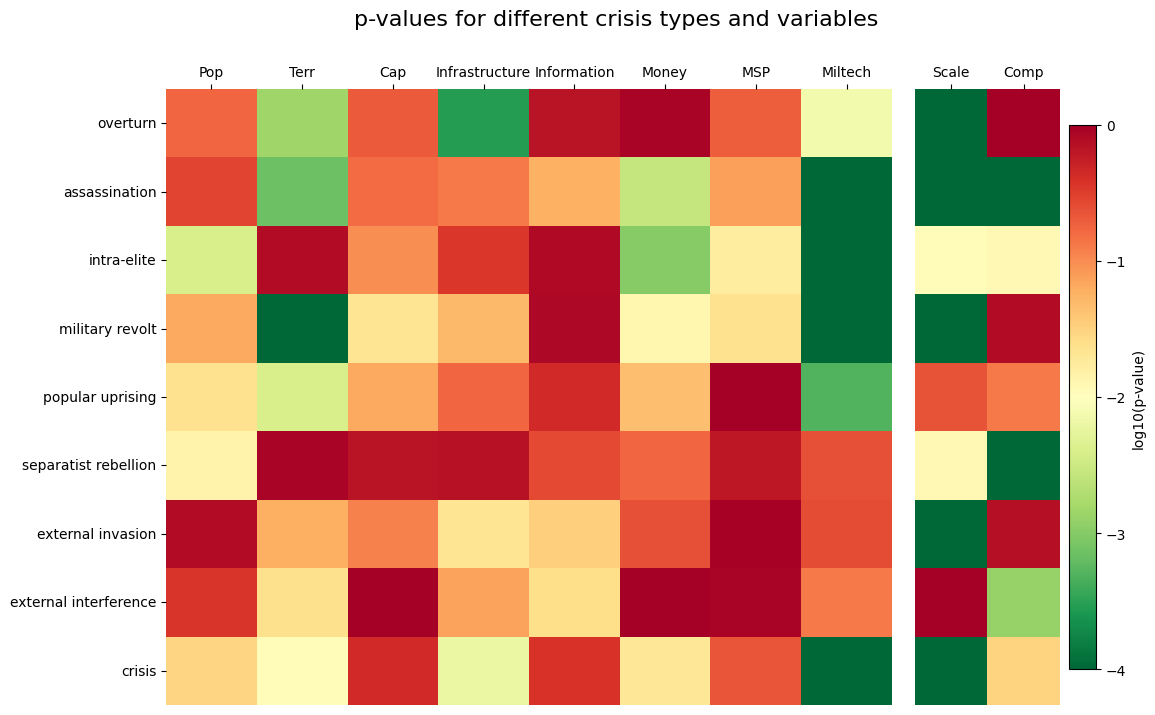

In [25]:
import matplotlib.gridspec as gridspec

# Split data into main and side sections
main_data = regression_results[['Pop','Terr','Cap', 'Infrastructure', 'Information', 'Money', 'MSP', 'Miltech']].apply(np.log10)
side_data = regression_results[['Scale','Comp']].apply(np.log10)

# Create figure with custom horizontal layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Plot main heatmap
ax1 = fig.add_subplot(gs[0])
sns.heatmap(main_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax1,
            cbar=False,
            xticklabels=True)

# Plot side heatmap without y labels
ax2 = fig.add_subplot(gs[1])
sns.heatmap(side_data, 
            cmap='RdYlGn_r', 
            alpha=1, 
            vmin=-4,
            ax=ax2,
            cbar=False,
            yticklabels=False,
            xticklabels=True)

# Set labels only for main plot
labels = ['overturn', 'assassination', 'intra-elite', 'military revolt', 
          'popular uprising', 'separatist rebellion', 'external invasion', 
          'external interference', 'crisis']
ax1.set_yticklabels(labels, rotation=0)

# Move x-axis labels to top for both plots
ax1.xaxis.set_ticks_position('top')
ax2.xaxis.set_ticks_position('top')

# Rotate x-axis labels for better readability
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')

# Create colorbar for the main heatmap
cbar = fig.colorbar(ax1.collections[0], ax=ax2, orientation='vertical')
cbar.set_label('log10(p-value)')
cbar.set_ticks([-4, -3, -2, -1, 0])

plt.tight_layout()
plt.suptitle('p-values for different crisis types and variables', fontsize=16)

testing religion

In [19]:
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp','religion_family']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
Xy = Xy.loc[Xy.religion_family.isin(['Christianity','Zoroastrianism'])]
print(Xy['religion_family'].unique())
Xy = pd.get_dummies(Xy, columns=['religion_family'], drop_first=True)
# drop_cols = ['religion_family_Non-Axial']
# Xy = Xy.drop(columns=drop_cols)
Xy['intercept'] = 1
X = Xy.drop(columns=[y_col])
y = Xy[y_col]

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

for rel_fam in dataset_PT.scv_imputed['religion_family'].unique():
    print(f"\nReligion family: {rel_fam}")
    # fit Christianity and Zoroastrianism separately
    x_cols = ['Scale_1', 'Comp']
    y_col = 'predecessor_assassination'
    # rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
    Xy = dataset_PT.scv_imputed[[y_col]+x_cols+['religion_family']].dropna()

    Xy = Xy.loc[Xy.religion_family.isin([rel_fam])]
    if len(Xy) > 20:
        Xy['intercept'] = 1
        X = Xy.drop(columns=[y_col,'religion_family'])
        y = Xy[y_col]

        logit_model = sm.Logit(y, X)
        result = logit_model.fit()

        print(result.summary())



['Christianity' 'Zoroastrianism']
Optimization terminated successfully.
         Current function value: 0.363503
         Iterations 6
                               Logit Regression Results                              
Dep. Variable:     predecessor_assassination   No. Observations:                  665
Model:                                 Logit   Df Residuals:                      661
Method:                                  MLE   Df Model:                            3
Date:                       Wed, 12 Mar 2025   Pseudo R-squ.:                 0.08676
Time:                               09:20:44   Log-Likelihood:                -241.73
converged:                              True   LL-Null:                       -264.70
Covariance Type:                   nonrobust   LLR p-value:                 5.862e-10
                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

Different kind of Scale and Comp plot

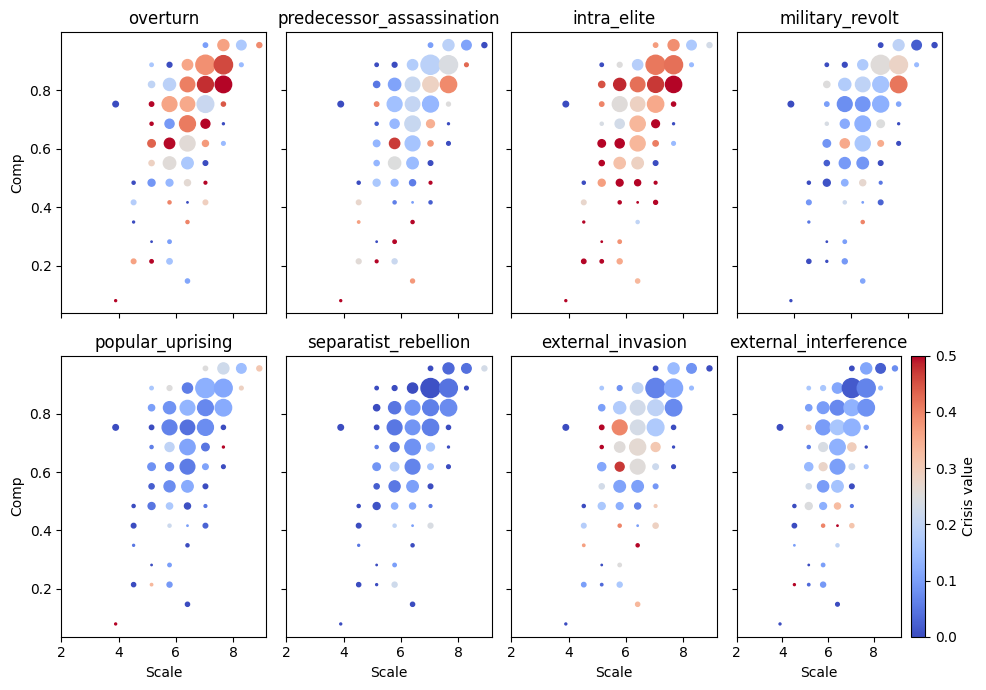

In [21]:
scv_imp = dataset_PT.scv_imputed#.loc[dataset_PT.scv_imputed.dataset == 'PT']
nbins = 15
scale = np.linspace(0, 10, nbins)
delta = scale[1] - scale[0]
comp = np.zeros(nbins)
comp_std = np.zeros(nbins)
crisis = np.zeros((len(crisis_vars), nbins))

for i in range(nbins):
    comp[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().mean()
    comp_std[i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)]['Comp'].dropna().std()
    for j, col in enumerate(crisis_vars):
        crisis[j, i] = scv_imp.loc[(scv_imp['Scale_1'] > scale[i]-delta) & (scv_imp['Scale_1'] < scale[i]+delta)][col].dropna().mean()

fig, axes = plt.subplots(2, 4, figsize=(10, 7))
axes = axes.flatten()
vmax = 0.5
for v in range(len(crisis_vars)):
    x_cols = ['Scale_1', 'Comp']
    y_col = crisis_vars[v]
    Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
    x = Xy[x_cols[0]].values
    y = Xy[x_cols[1]].values
    z = Xy[y_col].values

    grid_size = 15

    df = pd.DataFrame({'x': x, 'y': y, 'z': z})

    # Define the grid
    x_bins = np.linspace(0,10, grid_size + 1)
    y_bins = np.linspace(0,1, grid_size + 1)

    # Bin the data
    df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
    df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

    x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
    y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

    # Group by the bins and calculate the mean of z
    grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
    grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
    counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()
    x,y = np.meshgrid(x_bins, y_bins)

    axes[v].scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten(), vmax = 0.5)
    axes[v].grid(False)
    axes[v].set_title(crisis_vars[v])
    if v>=4:
        axes[v].set_xlabel('Scale')
    else:
        axes[v].set_xticklabels([])
    if (v == 0) or (v == 4):
        axes[v].set_ylabel('Comp')
    else:
        # remove y tick labels
        axes[v].set_yticklabels([])
    axes[v].set_yticks([0.2,0.4,0.6,0.8])
    axes[v].set_xticks([2,4,6,8])
# Add a colorbar to the last axis
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(0, vmax))
sm.set_array([])
fig.colorbar(sm, ax=axes[-1], orientation='vertical', label='Crisis value')
plt.tight_layout()
plt.show()

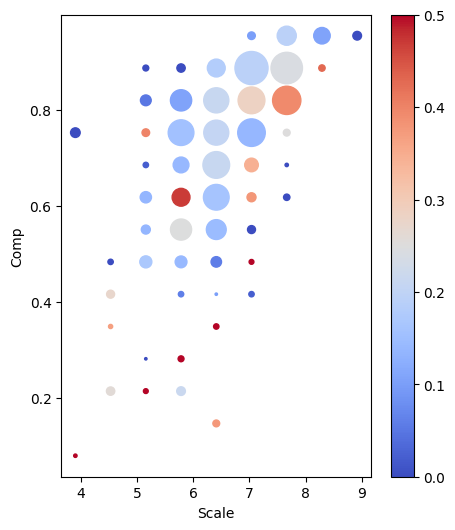

In [22]:
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
Xy = dataset_PT.scv_imputed[[y_col]+x_cols].dropna()
x = Xy[x_cols[0]].values
y = Xy[x_cols[1]].values
z = Xy[y_col].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(0,10, grid_size + 1)
y_bins = np.linspace(0,1, grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=3*counts.T.values.flatten(), vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')
plt.ylabel('Comp')
plt.grid(False)
# plt.title(crisis_vars)
plt.show()

# Causes of polity collapse

In [23]:
pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
polity_df = download_data("https://seshat-db.com/api/general/polities/")

Downloaded 448 rows


In [24]:
pred_df['next_polity'] = pred_df.preceding_entity.apply(lambda x: polity_df.loc[polity_df.long_name == x].new_name.values[0] if x in polity_df.long_name.values else np.nan)
pred_df = pred_df.dropna(subset=['next_polity'])
dataset_FULL.scv_imputed['polityEnd'] = dataset_100y.scv_imputed.PolityName.apply(lambda x: pred_df.loc[pred_df.next_polity == x].relationship_to_preceding_entity.values[0] if x in pred_df.next_polity.values else np.nan)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_81395/3693576637.py", line 1, in <module>
    pred_df['next_polity'] = pred_df.preceding_entity.apply(lambda x: polity_df.loc[polity_df.long_name == x].new_name.values[0] if x in polity_df.long_name.values else np.nan)
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/.venv/lib/python3.11/site-packages/pandas/core/series.py", line 4771, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

In [60]:
pred_df.relationship_to_preceding_entity.unique()

array(['continuity', None, 'absorption', 'population replacement',
       'elite replacement', 'unknown', 'territorial consolidation',
       'secession', 'vassalage'], dtype=object)

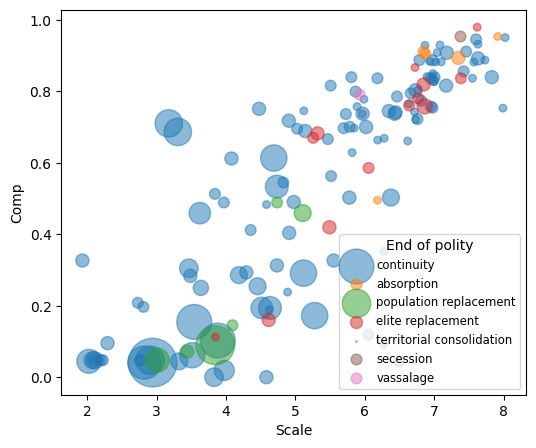

In [86]:
fig, ax = plt.subplots(figsize=(6, 5))
for rel in pred_df.relationship_to_preceding_entity.unique():
    if pd.isna(rel) or rel == 'unknown':
        continue
    dataset_plot = dataset_FULL.scv_imputed.loc[dataset_FULL.scv_imputed.dataset == '100y']
    dataset_plot = dataset_plot.loc[dataset_plot.polityEnd == rel].dropna(subset = ['Comp', 'Scale_1'])
    polity_group = dataset_plot.groupby('PolityName')
    
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    num_observations = polity_group.size()

    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        label = rel,
                        s=num_observations * 30,
                        alpha=0.5,
                        )



# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')

plt.legend(loc='lower right', fontsize='small', title='End of polity')

plt.show()

# Threads

In [101]:
pred_df = download_data( "https://seshat-db.com/api/general/polity-preceding-entities/")
polity_df = download_data('https://seshat-db.com/api/core/polities')

Downloaded 448 rows
Downloaded 863 rows


In [102]:
pred_df.relationship_to_preceding_entity.value_counts()

continuity                   253
elite replacement             48
population replacement        22
absorption                    14
secession                      9
unknown                        8
economic displacement          1
territorial consolidation      1
vassalage                      1
Name: relationship_to_preceding_entity, dtype: int64

In [103]:
pred_df.loc[pred_df.polity_new_name == 'ug_buganda_k_2', 'preceding_entity'] = 'ug_buganda_k_1'
pred_df.loc[pred_df.polity_new_name == 'gb_british_emp_1', 'preceding_entity'] = 'gb_england_tudor_and_early_stuart'
pred_df.loc[pred_df.polity_new_name == 'us_hawaii_k', 'preceding_entity'] = 'Hawaii III'
pred_df.loc[pred_df.polity_new_name == 'nkore_k_1', 'preceding_entity'] = 'Cwezi Dynasty'
pred_df.loc[pred_df.polity_new_name == 'ye_qasimid_dyn', 'preceding_entity'] = 'Ottoman Empire II'
pred_df.loc[pred_df.polity_new_name == 'de_hohenzollern_3', 'preceding_entity'] = 'Brandenburg-Prussia'


In [104]:

pred_df_remove = pred_df.copy()
pred_df_remove = pred_df_remove.sort_values('polity_start_year', ascending = False)
pred_df_remove.reset_index(drop=True, inplace=True)
threads = []

while len(pred_df_remove) > 0:
    new_thread = []
    polity = pred_df_remove.iloc[0]
    while True:
        new_thread.append(polity.polity_new_name)
        if pd.isna(polity.preceding_entity):
            mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pd.isna(pred_df_remove.preceding_entity))
            pred_df_remove = pred_df_remove.loc[~mask]
            pred_df_remove.reset_index(drop=True, inplace=True)
            break
        pol_name = polity_df.loc[polity_df.long_name == polity.preceding_entity, 'new_name']
        if len(pol_name) == 0:
            # look for slight variations in the name
            # look for times where the polity database name includes the name of the succeeding entity
            pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: polity.preceding_entity.lower() in x.lower() if pd.notna(x) else x), 'new_name']
            # look for times where the succeeding entity includes a name of the polity database name
            if len(pol_name) == 0:
                pol_name = polity_df.loc[polity_df.long_name.apply(lambda x: x.lower() in polity.preceding_entity.lower() if pd.notna(x) else x), 'new_name']
            # if still no match is found, remove the first row and break the loop
            if len(pol_name) == 0:
                mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
                pred_df_remove = pred_df_remove.loc[~mask]
                pred_df_remove.reset_index(drop=True, inplace=True)
                break
        if len(pol_name)>1:
            print(pol_name)
            
        pol_name = pol_name.iloc[0]
        print(pol_name)
        mask = (pred_df_remove.polity_new_name == polity.polity_new_name)&(pred_df_remove.preceding_entity == polity.preceding_entity)
        pred_df_remove = pred_df_remove.loc[~mask]
        pred_df_remove.reset_index(drop=True, inplace=True)
        polity = pred_df_remove[pred_df_remove.polity_new_name == pol_name]
        if len(polity) == 0:
            # polity proceeding entity exists in Seshat polity database but not in the preceding entities database
            new_thread.append(pol_name)
            break
        polity = polity.iloc[0]

    print(len(pred_df_remove))

    if len(new_thread) > 2:
        threads.append(new_thread[::-1])

cn_hmong_1
cn_qing_dyn_1
cn_ming_dyn
cn_yuan_dyn
mn_mongol_emp
mn_mongol_early
441
440
pg_orokaiva_pre_colonial
438
de_hohenzollern_2
de_hohenzollern_1
436
435
434
us_antebellum
433
gb_british_emp_1
431
430
429
ec_shuar_1
427
426
us_hawaii_3
us_hawaii_2
us_hawaii_1
422
ni_kwararafa
421
419
418
cn_qing_dyn_1
417
416
415
es_leon_k
414
th_ayutthaya
th_ayutthaya
412
us_hawaii_3
411
410
409
408
0    ug_nkore_k_2
0    ug_nkore_k_1
Name: new_name, dtype: object
ug_nkore_k_2
407
so_ajuran_sultanate
405
404
403
es_spanish_emp_1
es_castile_crown
401
ni_allada_k
399
398
ml_segou_k
396
in_mughal_emp
uz_timurid_emp
393
gh_akan
391
390
389
0    ug_buganda_k_1
0    ug_buganda_k_2
Name: new_name, dtype: object
ug_buganda_k_1
388
387
385
tr_ottoman_emp_2
tr_ottoman_emp_1
tr_ottoman_emirate
381
in_thanjavur_nayaks
in_vijayanagara_emp
in_delhi_sultanate
377
ni_allada_k
376
375
fr_bourbon_k_1
fr_valois_k_2
fr_valois_k_1
fr_capetian_k_2
fr_capetian_k_1
fr_carolingian_emp_2
fr_carolingian_emp_1
fr_merovingi

In [105]:
# remove duplicate threads
all_threads = []
for thread in threads:
    if thread not in all_threads:
        all_threads.append(thread)
threads = all_threads


['mn_mongol_early', 'mn_mongol_emp', 'cn_yuan_dyn', 'cn_ming_dyn', 'cn_qing_dyn_1', 'cn_hmong_1', 'cn_hmong_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


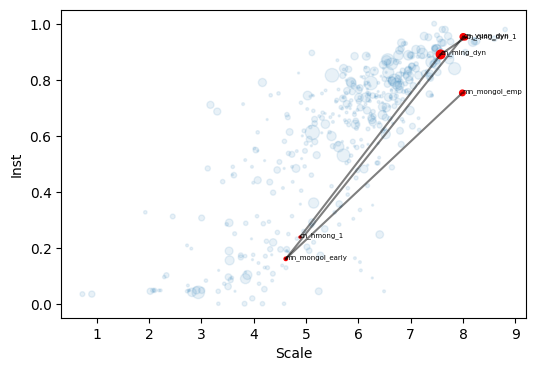

['fr_merovingian_emp_1', 'fr_merovingian_emp_2', 'fr_merovingian_emp_3', 'fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


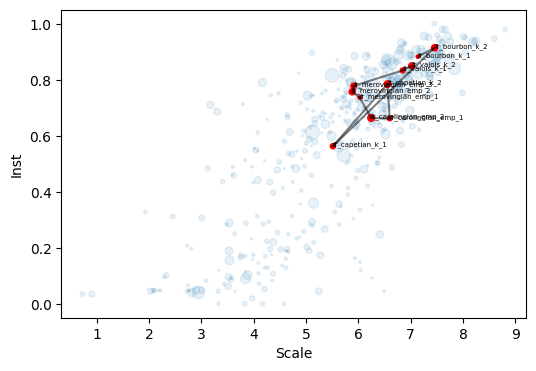

['kh_funan_1', 'kh_funan_2', 'kh_chenla', 'kh_angkor_1', 'kh_angkor_2', 'kh_angkor_3', 'kh_khmer_k']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


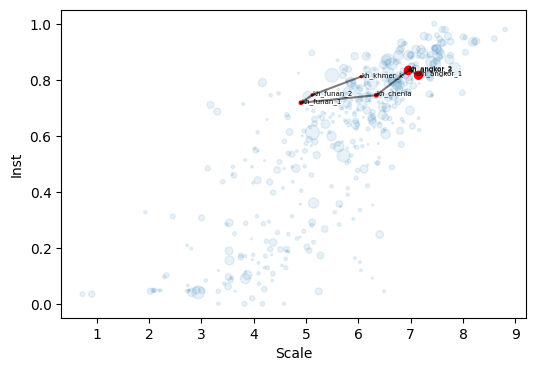

['sy_umayyad_cal', 'iq_abbasid_cal_1', 'eg_ayyubid_sultanate', 'eg_mamluk_sultanate_1', 'eg_mamluk_sultanate_2', 'eg_mamluk_sultanate_3']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


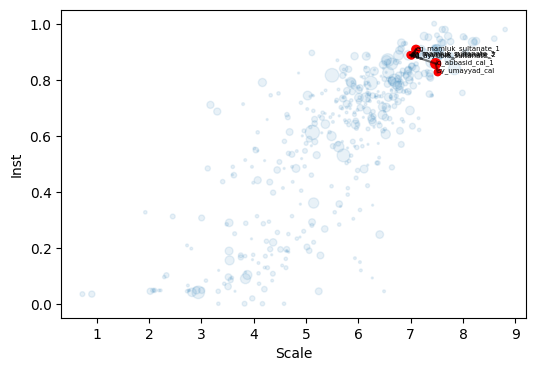

['in_kalabhra_dyn', 'in_pallava_emp_2', 'in_kadamba_emp', 'in_badami_chalukya_emp', 'in_rashtrakuta_emp', 'in_kalyani_chalukya_emp', 'in_hoysala_k']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


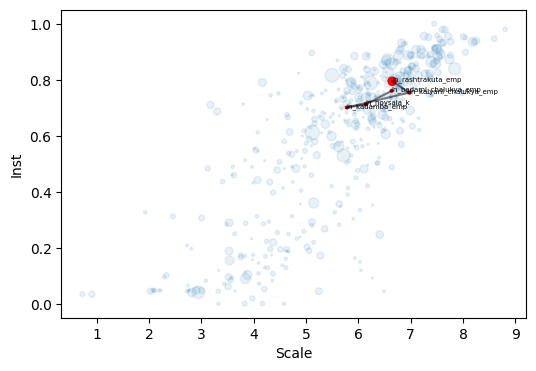

['gr_macedonian_emp', 'eg_ptolemaic_k_1', 'eg_ptolemaic_k_2', 'it_roman_principate', 'tr_roman_dominate', 'tr_east_roman_emp', 'tr_byzantine_emp_1', 'tr_byzantine_emp_2', 'tr_byzantine_emp_3', 'tr_rum_sultanate']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


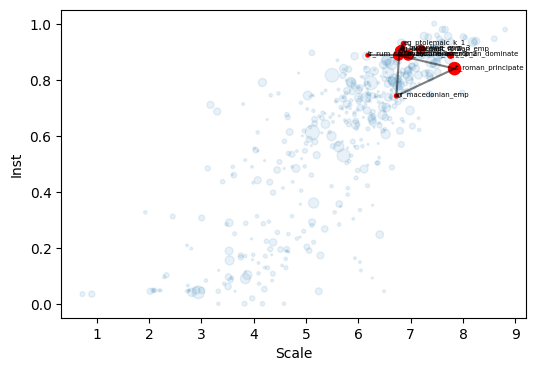

['us_woodland_1', 'us_woodland_2', 'us_woodland_3', 'us_woodland_4', 'us_woodland_5', 'us_emergent_mississippian_1', 'us_emergent_mississippian_2', 'us_cahokia_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


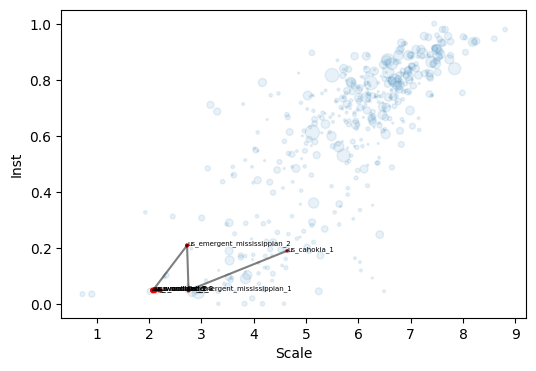

['cn_sui_dyn', 'cn_tang_dyn_1', 'mn_turk_khaganate_2', 'mn_uygur_khaganate', 'mn_khitan_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


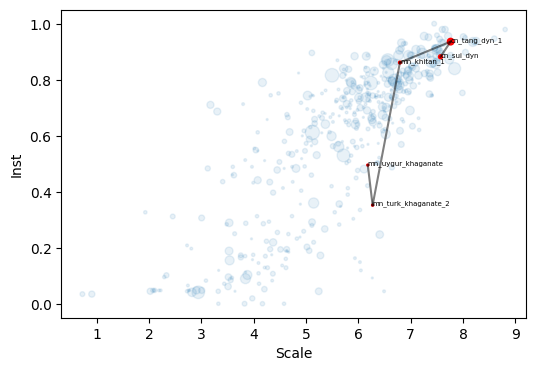

['jp_jomon_1', 'jp_jomon_2', 'jp_jomon_3', 'jp_jomon_4', 'jp_jomon_5', 'jp_jomon_6', 'jp_yayoi', 'jp_kofun']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


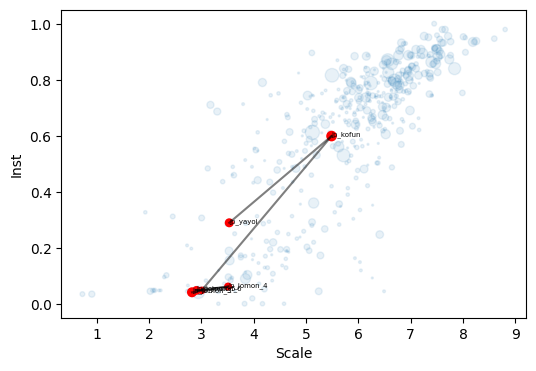

['it_latium_ca', 'it_latium_ba', 'it_latium_ia', 'it_roman_k', 'it_roman_rep_1', 'it_roman_rep_2', 'it_roman_rep_3']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


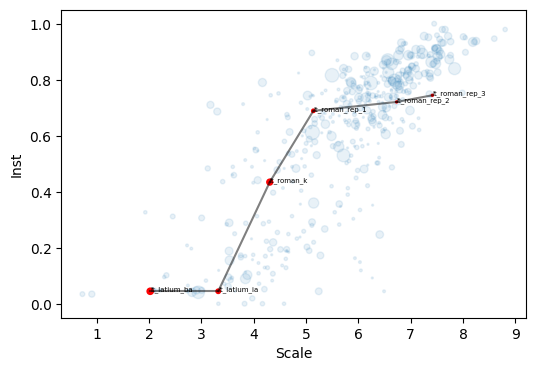

['fr_beaker_eba', 'fr_atlantic_complex', 'fr_hallstatt_a_b1', 'fr_hallstatt_b2_3', 'fr_hallstatt_c', 'fr_hallstatt_d', 'fr_la_tene_a_b1', 'fr_la_tene_b2_c1', 'fr_la_tene_c2_d']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


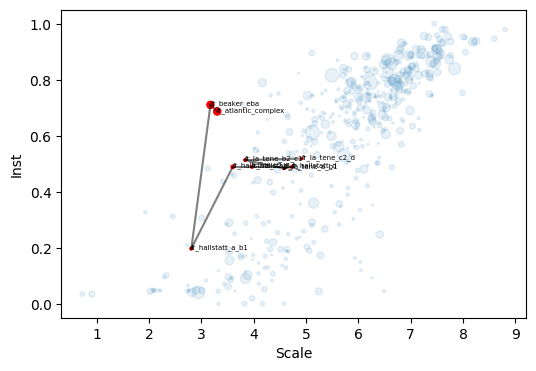

['eg_naqada_3', 'eg_dynasty_1', 'eg_dynasty_2', 'eg_old_k_1', 'eg_old_k_2', 'eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1', 'eg_new_k_2', 'eg_thebes_libyan', 'eg_kushite']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


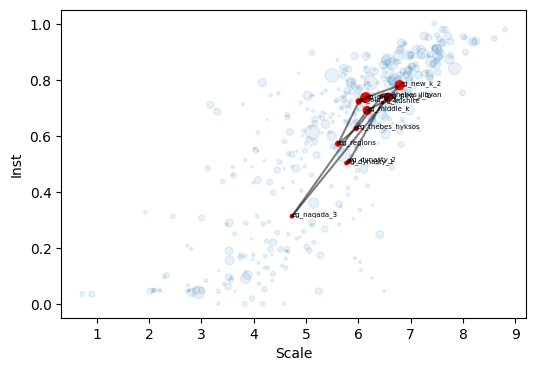

['tj_sarasm', 'kz_andronovo', 'uz_koktepe_1', 'uz_khwarasm_1', 'uz_koktepe_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


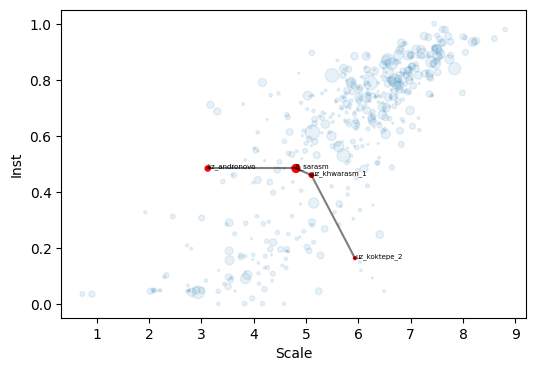

['cn_peiligang', 'cn_yangshao', 'cn_longshan', 'cn_erlitou', 'cn_erligang', 'cn_late_shang_dyn', 'cn_western_zhou_dyn', 'cn_jin_spring_and_autumn']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


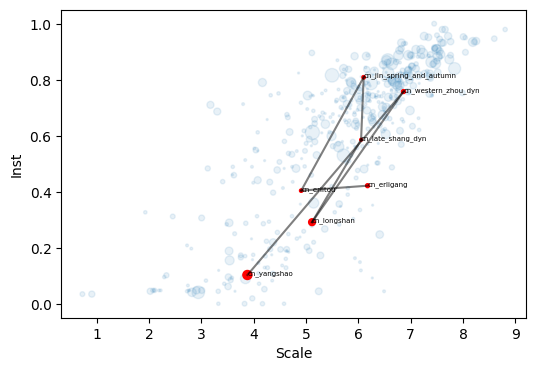

['tr_konya_lba', 'tr_hatti_old_k', 'tr_konya_lba', 'tr_hatti_new_k', 'tr_neo_hittite_k', 'tr_tabal_k', 'tr_phrygian_k']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


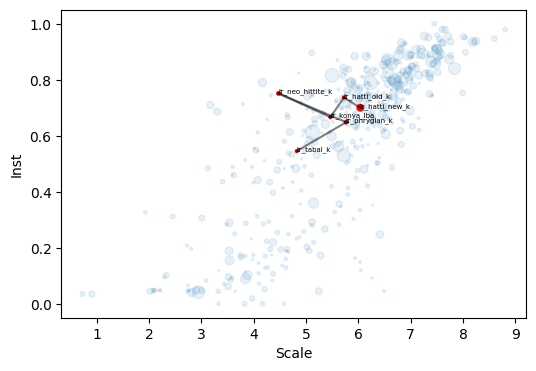

['pk_kachi_ca', 'pk_kachi_pre_urban', 'pk_kachi_urban_1', 'pk_kachi_urban_2', 'pk_kachi_post_urban', 'pk_kachi_proto_historic']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


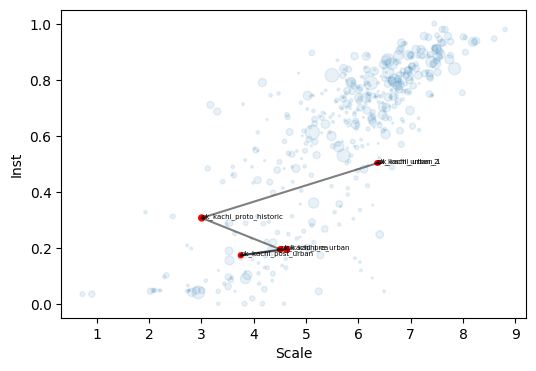

['ir_susiana_pre_ceramic', 'ir_susiana_formative', 'ir_susiana_archaic', 'ir_susiana_a', 'ir_susiana_b', 'ir_susiana_ubaid_1', 'ir_susiana_ubaid_2', 'ir_susa_1', 'ir_susa_2', 'ir_susa_3', 'ir_elam_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


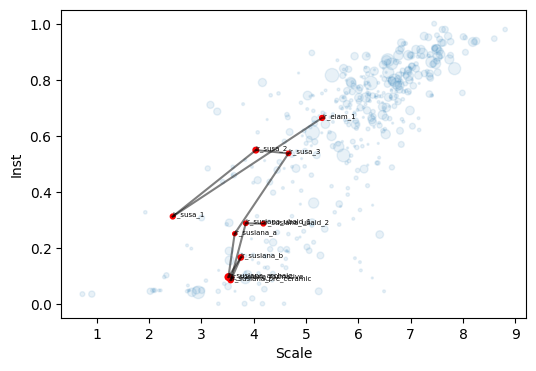

['tr_konya_enl', 'tr_konya_mnl', 'tr_konya_lnl', 'tr_konya_eca', 'tr_konya_lca', 'tr_konya_eba']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/1225011638.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = plt.scatter(mean_scale_1, mean_inst_1,


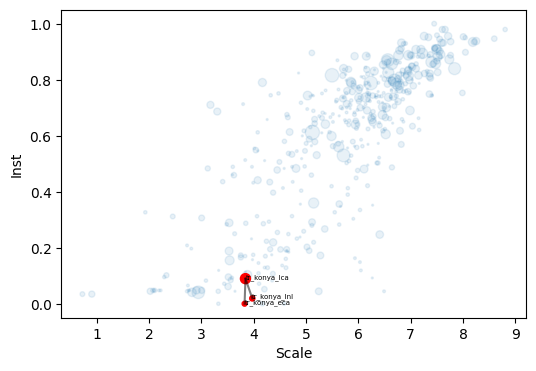

In [106]:
NGAs = dataset_FULL.scv_imputed['NGA'].unique()

for thread in threads:
    if len(thread) < 5:
        continue
    print(thread)

    dataset_plot = dataset_FULL.scv_imputed
    # dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
    polity_group = dataset_FULL.scv_imputed.groupby('PolityName')
    fig, ax = plt.subplots(figsize=(6, 4))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    v_max = mean_crisis.max()*0.6
    # add label with polity names on each bubble
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        # c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=0.1,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    thread_df = dataset_FULL.scv_imputed.loc[dataset_FULL.scv_imputed.PolityName.isin(thread)]
    thread_df.dropna(subset=['Comp', 'Scale_1'], inplace=True)
    polity_group = thread_df.groupby('PolityName')
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Comp'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    # mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    if pd.isna(mean_crisis).all() or pd.isna(mean_inst_1).all() or pd.isna(mean_scale_1).all():
        continue

    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.plot([mean_scale_1[i-1], mean_scale_1[i]], [mean_inst_1[i-1], mean_inst_1[i]], 'k-', alpha=0.5)
        # plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.04, head_length=0.15, fc='k', ec='k', length_includes_head = True, alpha = 0.5)
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        c='r',
                        # cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=1.0,
                        # edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    # Add a color bar
    # plt.colorbar(scatter, label='Crisis')

    # add label with polity names on each bubble
    for i, txt in enumerate(mean_scale_1.index):
        plt.annotate(txt, (mean_scale_1[i], mean_inst_1[i]), fontsize=5)

    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    # plt.title(nga)
    plt.show()

In [107]:
# flatten threads
threads_all_polities = [pol for thread in threads for pol in thread]
# find unique polities
threads_all_polities = list(set(threads_all_polities))

print(f"{len(threads_all_polities)} extracted polities in threads")
preceeding_pols = pred_df.polity_new_name.unique()
succeeding_pols = pred_df.preceding_entity.apply(lambda x: polity_df.loc[polity_df.long_name == x, 'new_name'].values[0] if len(polity_df.loc[polity_df.long_name == x, 'new_name']) > 0 else np.nan)
succeeding_pols = succeeding_pols.dropna().unique()

tot_pols = len(list(set(preceeding_pols).union(set(succeeding_pols))))
print(f"{tot_pols} total polities in threads")
nga_pols = len(dataset_100y.scv_imputed.loc[dataset_100y.scv_imputed.NGA.notna(),"PolityName"].unique())
print(f"{nga_pols} polities with NGA coded")


236 extracted polities in threads
468 total polities in threads
377 polities with NGA coded


In [108]:
# save threads as excel file
threads_df = pd.DataFrame(threads)
threads_df.to_excel('threads.xlsx')

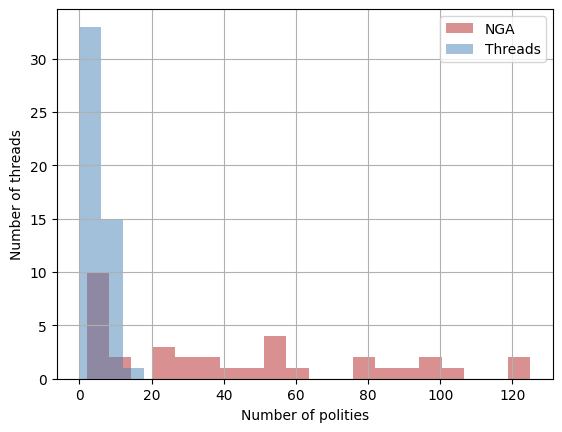

(array([ 0.,  3., 15.,  4.,  4.,  2.,  4.,  2.,  3.,  0.,  0.,  0.,  1.,
         1.,  1.,  2.,  0.,  2.,  0.,  0.]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400.,
        3600., 3800., 4000.]),
 <BarContainer object of 20 artists>)

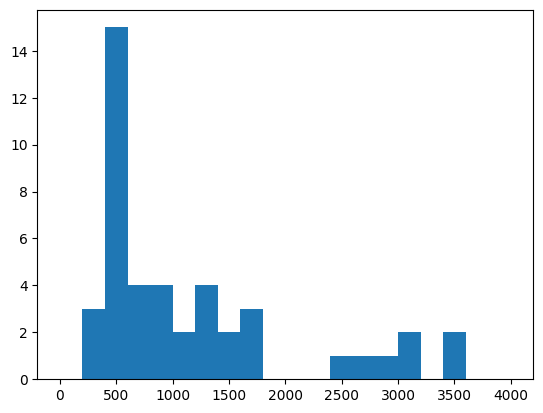

In [109]:
thread_lengths = [len(thread) for thread in threads]
thread_duration = []
for thread in threads:
    thread_df = dataset_100y.scv_imputed.loc[dataset_100y.scv_imputed.PolityName.isin(thread)]
    years = thread_df.Year.max() - thread_df.Year.min()
    thread_duration.append(years)


dataset_100y.scv_imputed.NGA.value_counts().hist(bins=20, label = 'NGA', color = 'firebrick', alpha = 0.5)
plt.hist(thread_lengths, bins = np.linspace(0,120, 21), label = 'Threads', color = 'steelblue', alpha = 0.5)
plt.legend()
plt.xlabel('Number of polities')
plt.ylabel('Number of threads')

plt.show()
plt.hist(thread_duration, bins = np.linspace(0,4000, 21))

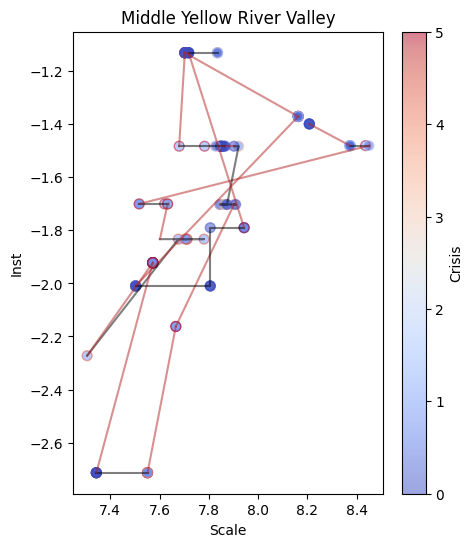

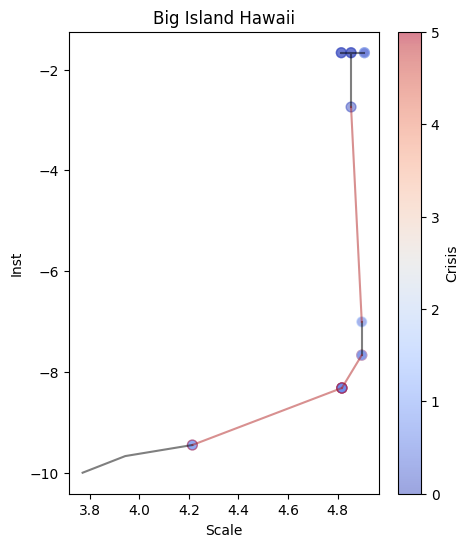

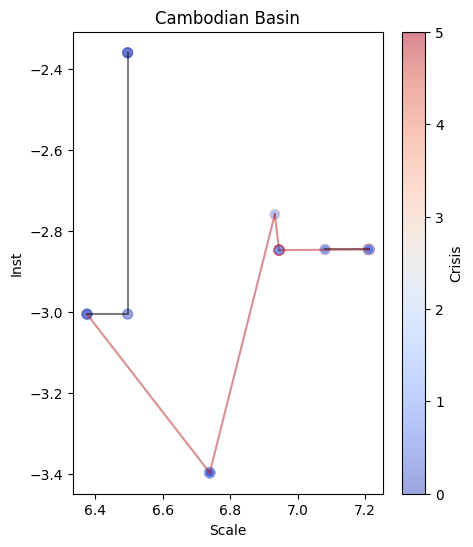

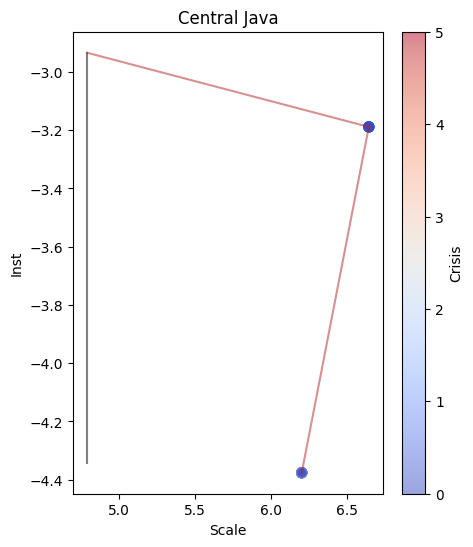

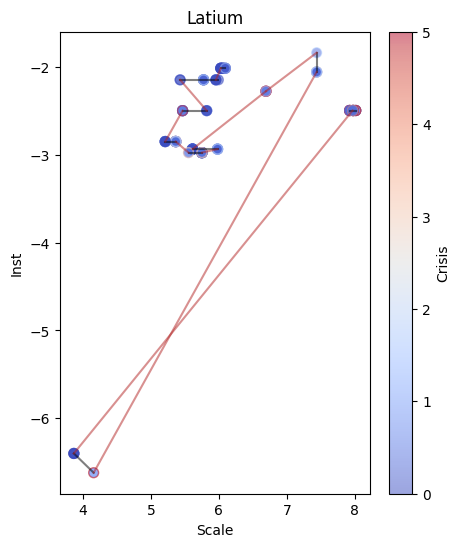

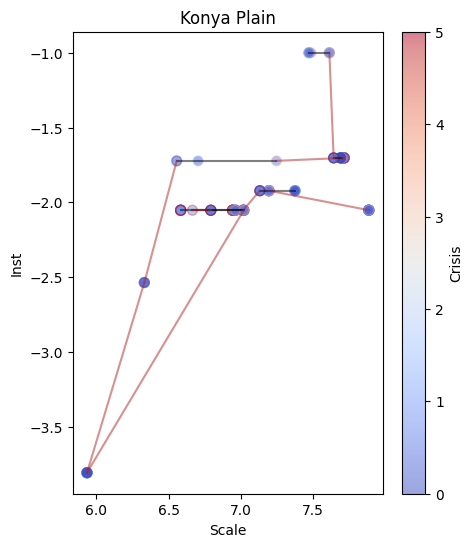

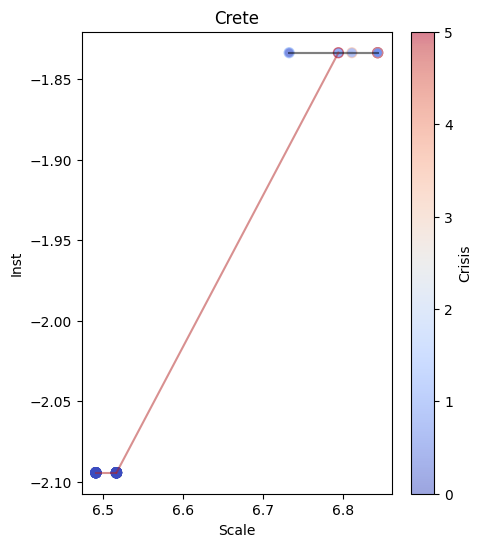

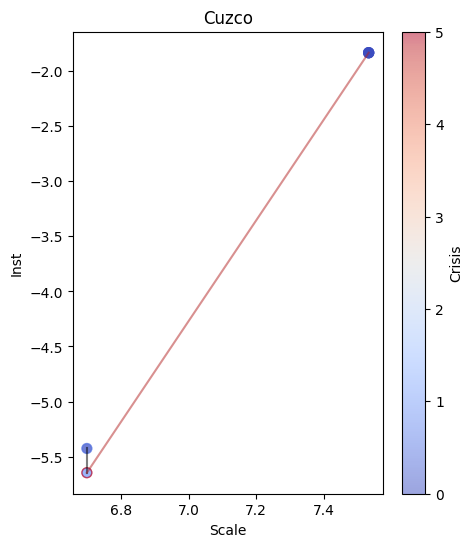

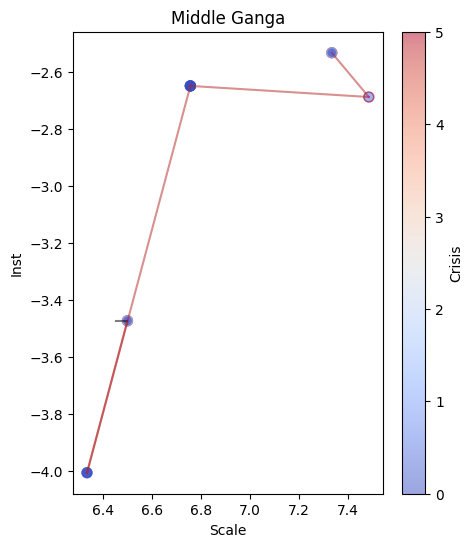

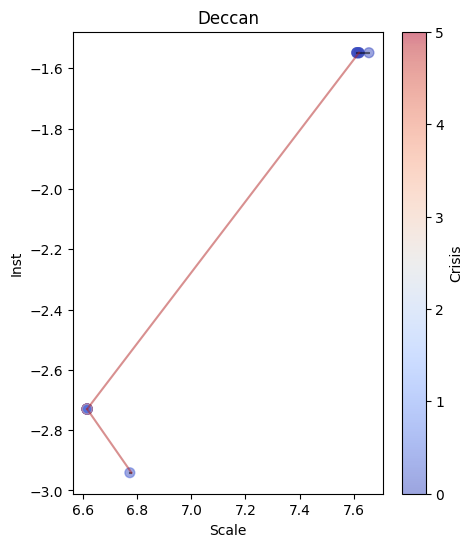

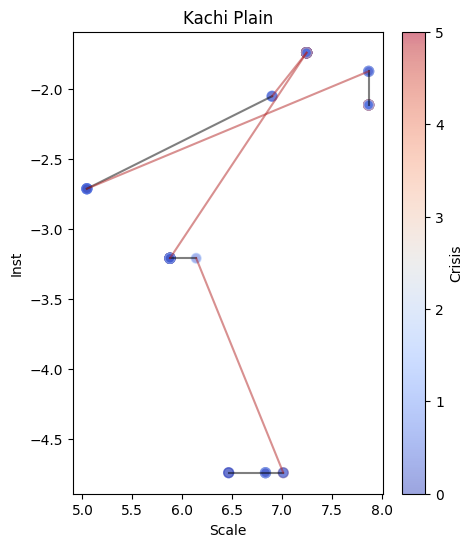

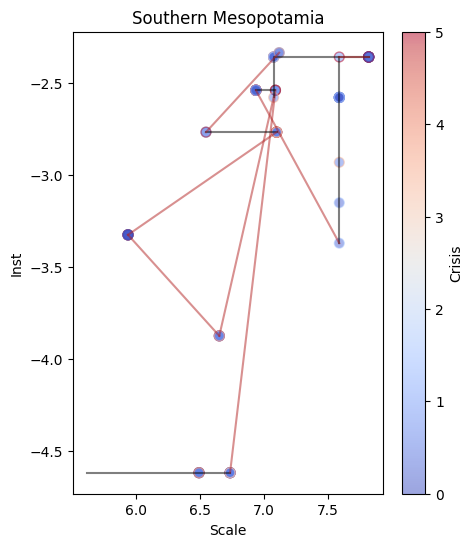

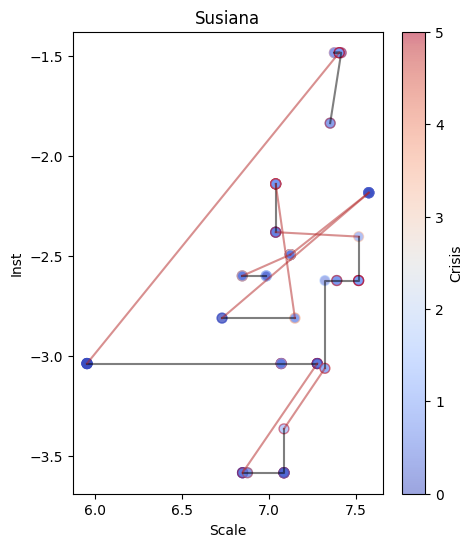

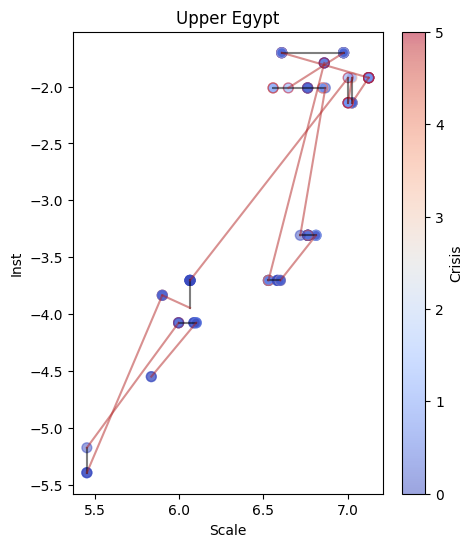

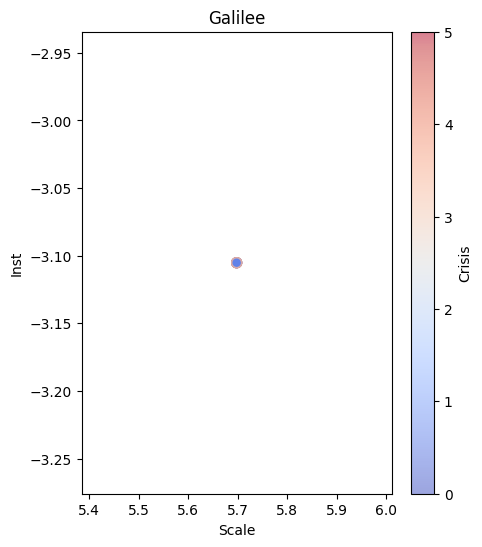

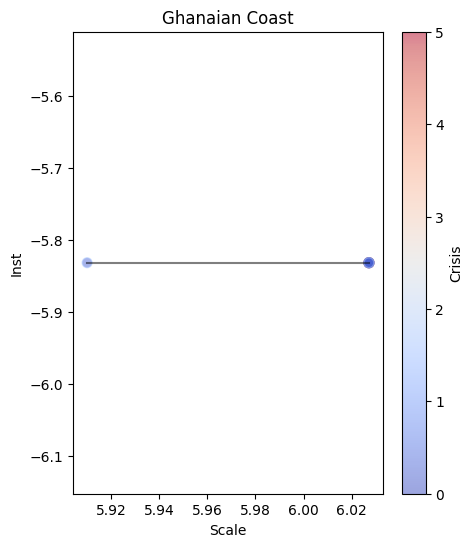

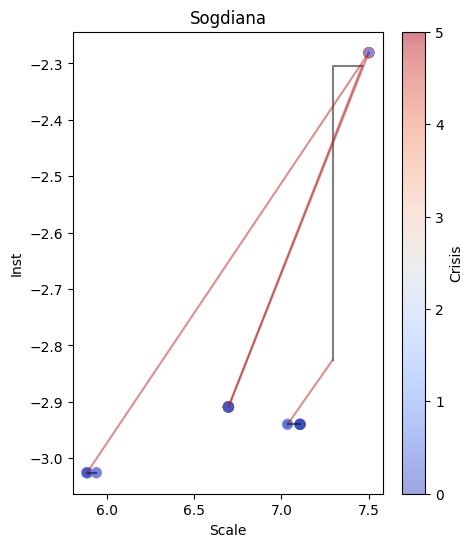

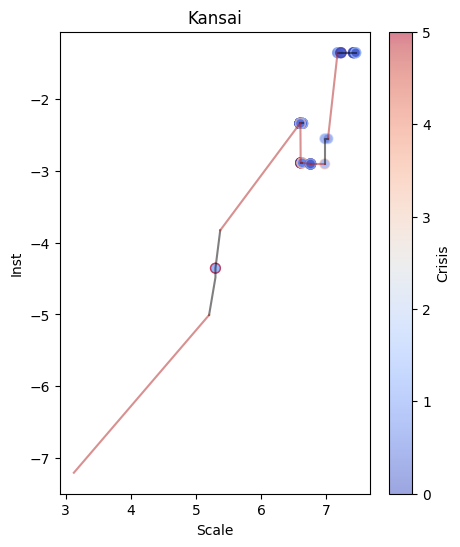

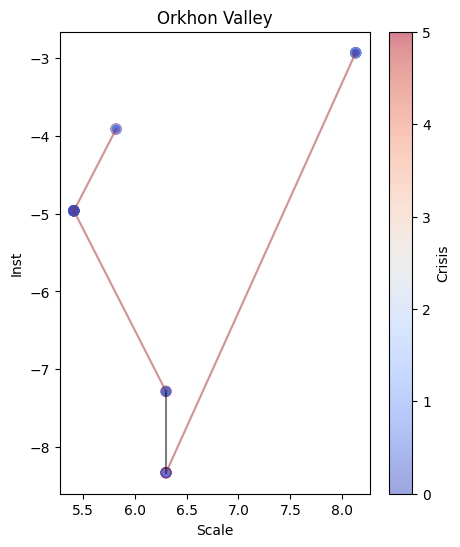

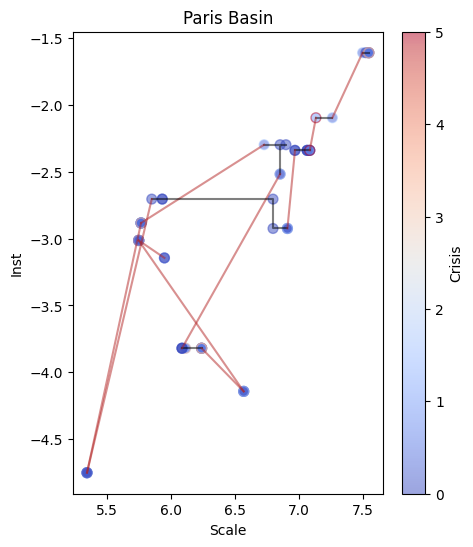

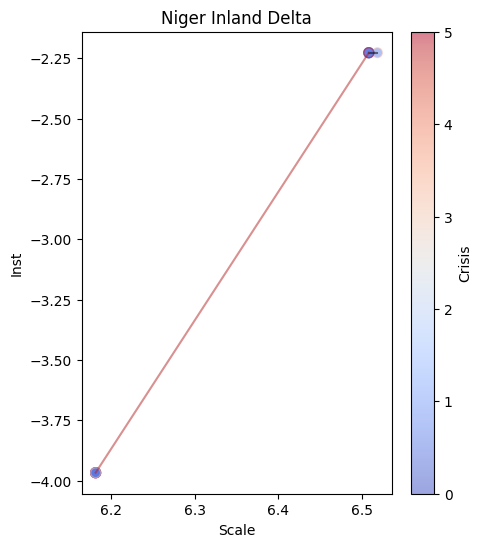

In [110]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:

    plot_df = dataset_PT.scv_imputed[dataset_PT.scv_imputed['NGA'] == nga]
    if len(plot_df) > 10:                
        fig, ax = plt.subplots(figsize=(5, 6))

        # Create a scatter plot
        scatter = plt.scatter(plot_df['Scale_1'], plot_df['Inst_1'],
                            vmin=0,
                            vmax = 5,
                            c=plot_df['Crisis'],
                            cmap='coolwarm',
                            s=50,
                            alpha=0.5,
                            edgecolors=plt.cm.coolwarm(plot_df['Crisis'] / plot_df['Crisis'].max())
                            )
        for i,pol in enumerate(plot_df['PolityName'].unique()):
            pol_df = plot_df[plot_df['PolityName'] == pol]
            plt.plot(pol_df['Scale_1'], pol_df['Inst_1'], 'k', alpha=0.5)
            if i > 0:
                prev_pol = plot_df[plot_df['PolityName'] == plot_df['PolityName'].unique()[i-1]]
                plt.plot([prev_pol['Scale_1'].iloc[-1], pol_df['Scale_1'].iloc[0]], [prev_pol['Inst_1'].iloc[-1], pol_df['Inst_1'].iloc[0]], 'firebrick', alpha=0.5)
            
        
        # Add a color bar
        plt.colorbar(scatter, label='Crisis')         
        # Show the plot
        plt.title(nga)
        plt.ylabel('Inst')
        plt.xlabel('Scale')
        plt.show()  
    


In [111]:
import pyreadr
dat = pyreadr.read_r("/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/TableData.Rdata")
data = dat['ImpSCDat']
data = data.loc[data.Dupl == 'n']
polity_df = download_data("https://seshatdata.com/api/core/polities/")
polity_df['duration'] = polity_df['end_year'] - polity_df['start_year']

KeyError: 'ImpSCDat'

In [ ]:
old_names = dataset_PT.scv_imputed['PolityName'].apply(lambda x: polity_df.loc[polity_df.new_name == x, "name"].iloc[0] if x in polity_df.new_name.values else np.nan)
to_keep = dataset_PT.scv_imputed.loc[(old_names.isin(data['PolID']))]
to_keep['PolID'] = old_names

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_72114/673438035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_keep['PolID'] = old_names


KeyError: 'Column not found: PolityDuration'

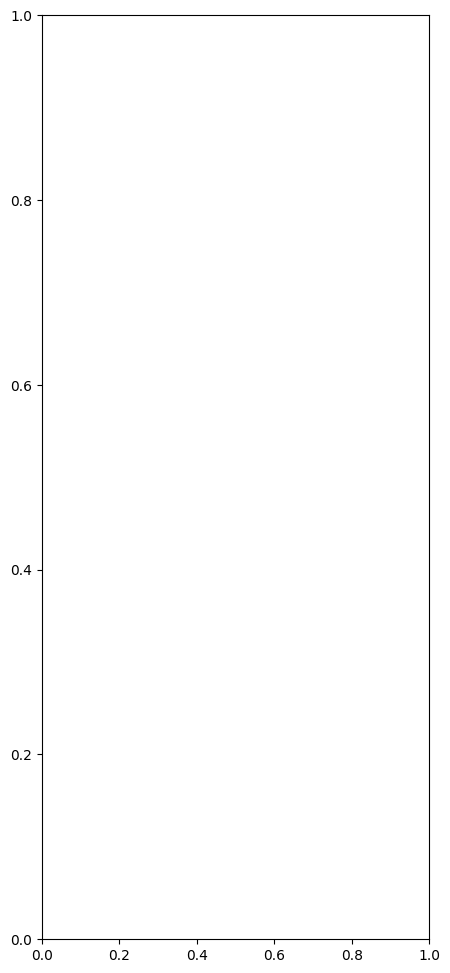

In [ ]:
import matplotlib.pyplot as plt

polity_group = to_keep.groupby('PolID')
fig, ax = plt.subplots(figsize=(5, 12))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Inst_1'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Crisis'].mean()
num_observations = polity_group.size()
duration = polity_group['PolityDuration'].mean()


threshold = 0.0
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    duration = duration[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]
    old_names = old_names.loc[old_names.isin(mean_crisis.index)]


v_max = 0.6 # mean_crisis.max()*.75
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='jet',
                      s=num_observations * 5,
                      alpha=0.8,
                      edgecolors=plt.cm.jet(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble
for i, txt in enumerate(mean_crisis.index):

    ax.annotate(txt, (mean_scale_1[i]-0.5, mean_inst_1[i]+0.1), fontsize=6)

# Show the plot
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()


In [ ]:
new_pols = to_keep.PolID.unique()
old_pols = data.PolID.unique()
common_polities = np.intersect1d(new_pols, old_pols)

col_dict = {'Gov':'Government', 'Infra':'Infrastructure', 'Info':'Information', 'Hier':'Hierarchy'}
data.rename(columns=col_dict, inplace=True)
relevant_cols = ['Pop','Terr','Cap','Hierarchy','Government','Infrastructure','Information','MSP']
diffs = np.zeros((len(common_polities), len(relevant_cols)))

for pol in common_polities:
    new_pol = to_keep.loc[to_keep.PolID == pol]
    old_pol = data.loc[data.PolID == pol]
    for col in relevant_cols:
        diff = new_pol[col].mean() - old_pol[col].mean()
        if pd.isna(new_pol[col].mean()) and pd.isna(old_pol[col].mean()):
            diff = 0
        diffs[np.where(common_polities == pol)[0][0], relevant_cols.index(col)] = diff

In [ ]:
plt.pcolor(diffs, cmap='coolwarm')
plt.clim(-10,10)
plt.xticks(np.arange(0.5, len(relevant_cols), 1), relevant_cols, rotation=45)
# remove yticks
plt.yticks([])
plt.ylabel('Polities')

plt.colorbar()